In [316]:
#Loading packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
from scipy.stats import norm
from random import sample
import seaborn as sns
import pandas as pd
from colossus.cosmology import cosmology
cosmo = cosmology.setCosmology('planck15');
from astropy.cosmology import Planck15
from astropy import units as u
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [317]:
#Loading lens file and dataframe
lens_file=pd.read_csv(r'/Users/nathaliechicoine/LSBG_research/LSBG_measurement/LSBG_catalog_v2.csv')
lens=pd.DataFrame(lens_file, columns= ['ra_se','dec_se', 'mag_gfm_g_corr', 'magerr_gfm_g', 'mag_gfm_i_corr','magerr_gfm_i', 'mag_gfm_r_corr','magerr_gfm_r','r_eff_r','flux_radius_g_asec'])

In [318]:
#Loading magnitude bands, errors, and masks 
g = lens['mag_gfm_g_corr']
g_err = lens['magerr_gfm_g']
i = lens['mag_gfm_i_corr']
i_err = lens['magerr_gfm_i']
r = lens['mag_gfm_r_corr']
r_err = lens['magerr_gfm_r']

mask_blue = (g-i)<=0.60
mask_red = (g-i)>=0.60
red_lens = lens[mask_red]
blue_lens = lens[mask_blue]

g_red = red_lens['mag_gfm_g_corr']
g_blue = blue_lens['mag_gfm_g_corr']
g_err_red = red_lens['magerr_gfm_g']
g_err_blue = blue_lens['magerr_gfm_g']

i_red = red_lens['mag_gfm_i_corr']
i_blue = blue_lens['mag_gfm_i_corr']
i_err_red = red_lens['magerr_gfm_i']
i_err_blue = blue_lens['magerr_gfm_i']

r_red = red_lens['mag_gfm_r_corr']
r_blue = blue_lens['mag_gfm_r_corr']
r_err_red = red_lens['magerr_gfm_r']
r_err_blue = blue_lens['magerr_gfm_r']

In [319]:
#Calculating distance to objects based on redshift (drawn from MCMC posterior)
def calculate_distance(zl_mean, zl_mean_err, zl_sigma, size):
    zlrange = np.linspace(zl_mean - zl_sigma, zl_mean + 3*zl_sigma, size)
    da = Planck15.comoving_distance(zl_mean)
    da_err = Planck15.comoving_distance(zl_mean_err)
    r_pc = np.array(da.to(u.parsec))
    r_pc_err = np.array(da_err.to(u.parsec)) 
    return r_pc, r_pc_err

In [320]:
#Calculating absolute magnitude for objects based on the distance and apparent magnitude
def absolute_magnitude(mag, distance, mag_error, distance_error):
    M_abs = mag-(5*np.log10(distance/10))
    M_abs_err = np.sqrt(mag_error**2 + (distance_error**2)*((-5/(np.log(10)*distance))**2)) #Propagated error for absolute magnitude equation
    return M_abs, M_abs_err

In [321]:
#Caculating color and color error
def color(mag_1, mag_2, mag_1_err, mag_2_err):
    color = mag_1-mag_2
    color_err = np.sqrt(mag_1_err**2 + mag_2_err**2) #Propagated error for color
    return color, color_err

In [9]:
#Calculating the mass-to-light ratio using the color mass-to-light relation (CMLR)
def CMLR(a, b, color, color_err): #a and b are constants for the CMLR
    m_l_ratio = 10**(a + b * (color)) #From Bell et al. 2003
    m_l_ratio_err = np.sqrt((np.log(10)*10**(a+b*color)*b)**2 * color_err**2) #Propagated error 
    return m_l_ratio, m_l_ratio_err

In [10]:
#Calculating the luminosity of the objects by comparing them to the solar luminosity
def lum(m_sol, m_abs, m_abs_err):
    lum = 10**(0.4*(m_sol-m_abs))
    lum_err = np.sqrt((np.log(10)*(-0.4)*10**(0.4*(m_sol - m_abs)))**2 * (m_abs_err)**2) #Propagated error
    return lum, lum_err

In [322]:
#Calculating the stellar mass by comparing the mass-to-light ratio to the luminosity
def stellar_mass(m_l_ratio, lum, m_l_ratio_err, lum_err):
    m_stellar = m_l_ratio*lum
    m_stellar_err = np.sqrt(((lum)**2 * (m_l_ratio_err)**2)+ ((m_l_ratio)**2 * lum_err**2)) #Propagated error 
    return m_stellar, m_stellar_err

In [323]:
#Defining constants
zl_mean_red = 13.2e-3
zl_mean_err_red = 0.003
zl_sigma_red = 0.01
a_i = -0.152  
b_i = 0.518 
m_sol = 4.54

#Calling functions
distance_red, distance_err_red = calculate_distance(zl_mean_red, zl_mean_err_red, zl_sigma_red, 7805)
i_abs_red, i_abs_err_red = absolute_magnitude(i_red, distance_red, i_err_red, distance_err_red)
colorgi_red, colorgi_red_err = color(g_red, i_red, g_err_red, i_err_red)
i_ml_ratio_red, i_ml_ratio_err_red = CMLR(a_i, b_i, colorgi_red, colorgi_red_err)
lum_i_red, lum_err_i_red = lum(m_sol, i_abs_red, i_abs_err_red)
m_stellar_red, m_stellar_err_red = stellar_mass(i_ml_ratio_red, lum_i_red, i_ml_ratio_err_red, lum_err_i_red)

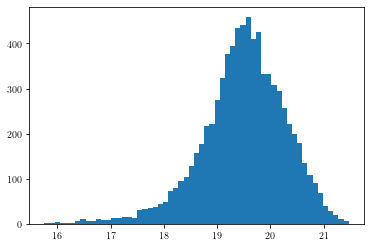

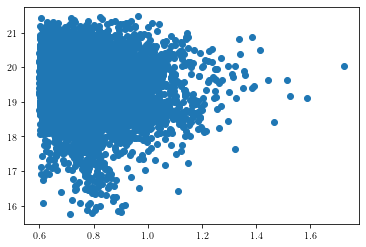

In [326]:
#Getting an idea of the distribution of magnitudes 
i_red_std = np.std(i_red)
i_red_mean = np.mean(i_red)
i_red_err_std = np.std(i_err_red)
i_red_err_mean = np.mean(i_err_red)
plt.hist(i_red, bins='auto')
#plt.hist(i_red_sample_1, bins='auto', color='green')
plt.show()

plt.scatter(colorgi_red, i_red)

In [327]:
#Resampling the magnitudes based on the error
simulated_magnitudes = []
for mag, error in zip(i_red, i_err_red):
    simulated_magnitude = np.random.normal(loc=mag, scale=error)
    simulated_magnitudes.append(simulated_magnitude)


In [328]:
simulated_magnitudes_v2 = []
for mag, error in zip(i_red, i_err_red):
    simulated_magnitude_v2 = np.random.normal(loc=mag, scale=error)
    simulated_magnitudes_v2.append(simulated_magnitude_v2)


In [329]:
simulated_magnitudes_v3 = []
for mag, error in zip(i_red, i_err_red):
    simulated_magnitude_v3 = np.random.normal(loc=mag, scale=error)
    simulated_magnitudes_v3.append(simulated_magnitude_v3)


In [330]:
simulated_magnitudes_v4 = []
for mag, error in zip(i_red, i_err_red):
    simulated_magnitude_v4 = np.random.normal(loc=mag, scale=error)
    simulated_magnitudes_v4.append(simulated_magnitude_v4)


In [331]:
simulated_magnitudes_v5 = []
for mag, error in zip(i_red, i_err_red):
    simulated_magnitude_v5 = np.random.normal(loc=mag, scale=error)
    simulated_magnitudes_v5.append(simulated_magnitude_v5)


In [332]:
simulated_magnitudes_v6 = []
for mag, error in zip(i_red, i_err_red):
    simulated_magnitude_v6 = np.random.normal(loc=mag, scale=error)
    simulated_magnitudes_v6.append(simulated_magnitude_v6)


In [333]:
simulated_magnitudes_v7 = []
for mag, error in zip(i_red, i_err_red):
    simulated_magnitude_v7 = np.random.normal(loc=mag, scale=error)
    simulated_magnitudes_v7.append(simulated_magnitude_v7)


In [334]:
simulated_magnitudes_v8 = []
for mag, error in zip(i_red, i_err_red):
    simulated_magnitude_v8 = np.random.normal(loc=mag, scale=error)
    simulated_magnitudes_v8.append(simulated_magnitude_v8)


In [335]:
simulated_magnitudes_v9 = []
for mag, error in zip(i_red, i_err_red):
    simulated_magnitude_v9 = np.random.normal(loc=mag, scale=error)
    simulated_magnitudes_v9.append(simulated_magnitude_v9)


In [336]:
simulated_magnitudes_v10 = []
for mag, error in zip(i_red, i_err_red):
    simulated_magnitude_v10 = np.random.normal(loc=mag, scale=error)
    simulated_magnitudes_v10.append(simulated_magnitude_v10)


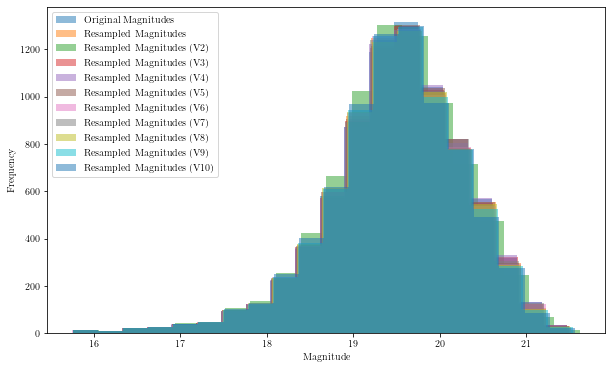

In [338]:
#Plotting the resampled magnitudes
plt.figure(figsize=(10, 6))
plt.hist(i_red, bins=20, alpha=0.5, label="Original Magnitudes")
plt.hist(simulated_magnitudes, bins=20, alpha=0.5, label="Resampled Magnitudes")
plt.hist(simulated_magnitudes_v2, bins=20, alpha=0.5, label="Resampled Magnitudes (V2)")
plt.hist(simulated_magnitudes_v3, bins=20, alpha=0.5, label="Resampled Magnitudes (V3)")
plt.hist(simulated_magnitudes_v4, bins=20, alpha=0.5, label="Resampled Magnitudes (V4)")
plt.hist(simulated_magnitudes_v5, bins=20, alpha=0.5, label="Resampled Magnitudes (V5)")
plt.hist(simulated_magnitudes_v6, bins=20, alpha=0.5, label="Resampled Magnitudes (V6)")
plt.hist(simulated_magnitudes_v7, bins=20, alpha=0.5, label="Resampled Magnitudes (V7)")
plt.hist(simulated_magnitudes_v8, bins=20, alpha=0.5, label="Resampled Magnitudes (V8)")
plt.hist(simulated_magnitudes_v9, bins=20, alpha=0.5, label="Resampled Magnitudes (V9)")
plt.hist(simulated_magnitudes_v10, bins=20, alpha=0.5, label="Resampled Magnitudes (V10)")
plt.xlabel("Magnitude")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [339]:
#Calculating the absolute magnitude, luminosity, and stellar mass based on the resampled magnitudes
i_abs_red_simulated, i_abs_err_red_simulated = absolute_magnitude(simulated_magnitudes, distance_red, i_err_red, distance_err_red)
lum_i_red_simulated, lum_err_i_red_simulated = lum(m_sol, i_abs_red_simulated, i_abs_err_red_simulated)
m_stellar_red_simulated, m_stellar_err_red_simulated = stellar_mass(i_ml_ratio_red, lum_i_red_simulated, i_ml_ratio_err_red, lum_err_i_red_simulated)

i_abs_red_simulated_v2, i_abs_err_red_simulated_v2 = absolute_magnitude(simulated_magnitudes_v2, distance_red, i_err_red, distance_err_red)
lum_i_red_simulated_v2, lum_err_i_red_simulated_v2 = lum(m_sol, i_abs_red_simulated_v2, i_abs_err_red_simulated_v2)
m_stellar_red_simulated_v2, m_stellar_err_red_simulated_v2 = stellar_mass(i_ml_ratio_red, lum_i_red_simulated_v2, i_ml_ratio_err_red, lum_err_i_red_simulated_v2)

i_abs_red_simulated_v3, i_abs_err_red_simulated_v3 = absolute_magnitude(simulated_magnitudes_v3, distance_red, i_err_red, distance_err_red)
lum_i_red_simulated_v3, lum_err_i_red_simulated_v3 = lum(m_sol, i_abs_red_simulated_v3, i_abs_err_red_simulated_v3)
m_stellar_red_simulated_v3, m_stellar_err_red_simulated_v3 = stellar_mass(i_ml_ratio_red, lum_i_red_simulated_v3, i_ml_ratio_err_red, lum_err_i_red_simulated_v3)

i_abs_red_simulated_v4, i_abs_err_red_simulated_v4 = absolute_magnitude(simulated_magnitudes_v4, distance_red, i_err_red, distance_err_red)
lum_i_red_simulated_v4, lum_err_i_red_simulated_v4 = lum(m_sol, i_abs_red_simulated_v4, i_abs_err_red_simulated_v4)
m_stellar_red_simulated_v4, m_stellar_err_red_simulated_v4 = stellar_mass(i_ml_ratio_red, lum_i_red_simulated_v4, i_ml_ratio_err_red, lum_err_i_red_simulated_v4)

i_abs_red_simulated_v5, i_abs_err_red_simulated_v5 = absolute_magnitude(simulated_magnitudes_v5, distance_red, i_err_red, distance_err_red)
lum_i_red_simulated_v5, lum_err_i_red_simulated_v5 = lum(m_sol, i_abs_red_simulated_v5, i_abs_err_red_simulated_v5)
m_stellar_red_simulated_v5, m_stellar_err_red_simulated_v5 = stellar_mass(i_ml_ratio_red, lum_i_red_simulated_v5, i_ml_ratio_err_red, lum_err_i_red_simulated_v5)

i_abs_red_simulated_v6, i_abs_err_red_simulated_v6 = absolute_magnitude(simulated_magnitudes_v6, distance_red, i_err_red, distance_err_red)
lum_i_red_simulated_v6, lum_err_i_red_simulated_v6 = lum(m_sol, i_abs_red_simulated_v6, i_abs_err_red_simulated_v6)
m_stellar_red_simulated_v6, m_stellar_err_red_simulated_v6 = stellar_mass(i_ml_ratio_red, lum_i_red_simulated_v6, i_ml_ratio_err_red, lum_err_i_red_simulated_v6)

i_abs_red_simulated_v7, i_abs_err_red_simulated_v7 = absolute_magnitude(simulated_magnitudes_v7, distance_red, i_err_red, distance_err_red)
lum_i_red_simulated_v7, lum_err_i_red_simulated_v7 = lum(m_sol, i_abs_red_simulated_v7, i_abs_err_red_simulated_v7)
m_stellar_red_simulated_v7, m_stellar_err_red_simulated_v7 = stellar_mass(i_ml_ratio_red, lum_i_red_simulated_v7, i_ml_ratio_err_red, lum_err_i_red_simulated_v7)

i_abs_red_simulated_v8, i_abs_err_red_simulated_v8 = absolute_magnitude(simulated_magnitudes_v8, distance_red, i_err_red, distance_err_red)
lum_i_red_simulated_v8, lum_err_i_red_simulated_v8 = lum(m_sol, i_abs_red_simulated_v8, i_abs_err_red_simulated_v8)
m_stellar_red_simulated_v8, m_stellar_err_red_simulated_v8 = stellar_mass(i_ml_ratio_red, lum_i_red_simulated_v8, i_ml_ratio_err_red, lum_err_i_red_simulated_v8)

i_abs_red_simulated_v9, i_abs_err_red_simulated_v9 = absolute_magnitude(simulated_magnitudes_v9, distance_red, i_err_red, distance_err_red)
lum_i_red_simulated_v9, lum_err_i_red_simulated_v9 = lum(m_sol, i_abs_red_simulated_v9, i_abs_err_red_simulated_v9)
m_stellar_red_simulated_v9, m_stellar_err_red_simulated_v9 = stellar_mass(i_ml_ratio_red, lum_i_red_simulated_v9, i_ml_ratio_err_red, lum_err_i_red_simulated_v9)

i_abs_red_simulated_v10, i_abs_err_red_simulated_v10 = absolute_magnitude(simulated_magnitudes_v10, distance_red, i_err_red, distance_err_red)
lum_i_red_simulated_v10, lum_err_i_red_simulated_v10 = lum(m_sol, i_abs_red_simulated_v10, i_abs_err_red_simulated_v10)
m_stellar_red_simulated_v10, m_stellar_err_red_simulated_v10 = stellar_mass(i_ml_ratio_red, lum_i_red_simulated_v10, i_ml_ratio_err_red, lum_err_i_red_simulated_v10)


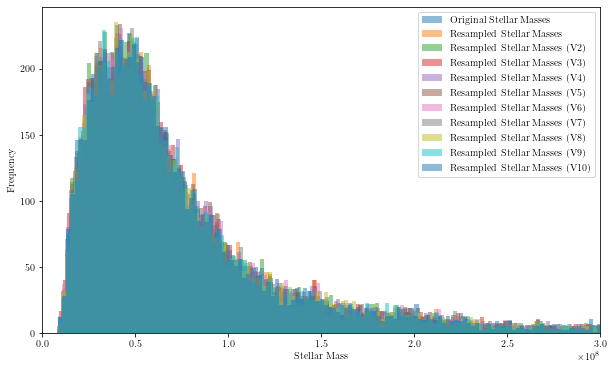

In [340]:
#Plotting the resampled stellar masses derived from the resampled magnitudes
plt.figure(figsize=(10, 6))
plt.hist(m_stellar_red, bins=1000, alpha=0.5, label="Original Stellar Masses")
plt.hist(m_stellar_red_simulated, bins=1000, alpha=0.5, label="Resampled Stellar Masses")
plt.hist(m_stellar_red_simulated_v2, bins=1000, alpha=0.5, label="Resampled Stellar Masses (V2)")
plt.hist(m_stellar_red_simulated_v3, bins=1000, alpha=0.5, label="Resampled Stellar Masses (V3)")
plt.hist(m_stellar_red_simulated_v4, bins=1000, alpha=0.5, label="Resampled Stellar Masses (V4)")
plt.hist(m_stellar_red_simulated_v5, bins=1000, alpha=0.5, label="Resampled Stellar Masses (V5)")
plt.hist(m_stellar_red_simulated_v6, bins=1000, alpha=0.5, label="Resampled Stellar Masses (V6)")
plt.hist(m_stellar_red_simulated_v7, bins=1000, alpha=0.5, label="Resampled Stellar Masses (V7)")
plt.hist(m_stellar_red_simulated_v8, bins=1000, alpha=0.5, label="Resampled Stellar Masses (V8)")
plt.hist(m_stellar_red_simulated_v9, bins=1000, alpha=0.5, label="Resampled Stellar Masses (V9)")
plt.hist(m_stellar_red_simulated_v10, bins=1000, alpha=0.5, label="Resampled Stellar Masses (V10)")
plt.xlabel("Stellar Mass")
plt.ylabel("Frequency")
plt.legend()
plt.xlim(0,0.3e9)
plt.savefig('stellar_mass_distribution.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [341]:
#Printing out the median and standard deviation of the stellar mass distribution and the stellar mass error distribution
print(np.median(m_stellar_red))
print(np.median(m_stellar_err_red))
print(np.std(m_stellar_red))
print(np.std(m_stellar_err_red))

58989714.99021852
27203148.063063525
129599712.6849919
59104973.10365507


In [291]:
#Defining parameters for the parameterized stellar-halo-mass relation, as defined in Moster et al(2010)
M_halo_red = 9.9e10 #subhalo mass from MCMC posterior distribution 
A = 0.02817 #Normalization of the SHMR at the characteristic halo mass
M_char = 10**11.899 #Characteristic halo mass 
beta= 1.068 #Slope at low-mass end
gamma= 0.611 #Slope at high-mass end
m_halo_ex_red = np.linspace(5e10, 1e15, 100000) #Array of halo masses for the parameterized relation
m_stellar_ex_red = m_halo_ex_red*2 * A * (((m_halo_ex_red/M_char)**(-1*beta)) + ((m_halo_ex_red/M_char)**gamma))**(-1) #Calculation of the parameterized SHMR
M_halo_err_red = 2.2e10 #Error given by the MCMC posterior 

In [293]:
#Parameter uncertainties for SHMR
A_up_err = 0.00063
A_low_err = -0.00057
M_char_up_err =  10**(2*0.026)
M_char_low_err =  - 10**(2*0.024)
beta_up_err = 0.051
beta_low_err = -0.044
gamma_up_err = 0.012
gamma_low_err = -0.010

#Propagated error calculations for parameterized SHMR based on parameter uncertainties
m_stellar_err_m_halo = np.sqrt(((-2*A*(m_halo_ex_red/M_char)**(beta)*(-1-beta-(m_halo_ex_red/M_char)**(beta+gamma))+gamma*(m_halo_ex_red/M_char)**(beta+gamma))/(1+ (m_halo_ex_red/M_char)**(beta+gamma))**2)**2 * M_halo_err_red**2)
m_stellar_err_A = np.sqrt(((2*m_halo_ex_red)/((m_halo_ex_red/M_char)**(-1*beta) +(m_halo_ex_red/M_char)**gamma))**2 * (2*0.00063)**2)
m_stellar_err_beta = np.sqrt(((2*A*m_halo_ex_red*(m_halo_ex_red/M_char)**(-1*beta) * np.log(m_halo_ex_red/M_char))/(((m_halo_ex_red/M_char)**(-1*beta) + (m_halo_ex_red/M_char)**gamma)**2))**2 * (2*0.051)**2)
m_stellar_err_gamma = np.sqrt((-2*A*m_halo_ex_red*((m_halo_ex_red/M_char)**gamma)*np.log(m_halo_ex_red/M_char)/((m_halo_ex_red/M_char)**(-1*beta) + (m_halo_ex_red/M_char)**gamma)**2)**2 * (2*0.012)**2)
m_stellar_M_char = np.sqrt((-2*A*m_halo_ex_red*(((beta*m_halo_ex_red*(m_halo_ex_red/M_char)**(-1*beta -1))/M_char**2) - ((gamma*m_halo_ex_red*(m_halo_ex_red/M_char)**(gamma-1))/M_char**2))/(((m_halo_ex_red/M_char)**(-1*beta) + (m_halo_ex_red/M_char)**gamma)**2))**2 * (10**(2*0.026))**2)

m_stellar_ex_red_err_prop = m_stellar_err_m_halo + m_stellar_err_A + m_stellar_err_beta + m_stellar_err_gamma + m_stellar_M_char

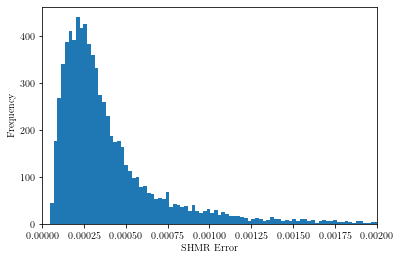

In [342]:
#Propagated error distribution for direct calculation of SHMR (M_stellar/M_halo)
y=np.array([1])
shmr_error_red = np.sqrt(((1/M_halo_red)**2 * (m_stellar_err_red)**2) + ((-m_stellar_red/M_halo_red**2)**2)*(M_halo_err_red)**2)
plt.hist(shmr_error_red, bins=500)
plt.xlim(0,0.002)
plt.xlabel('SHMR Error')
plt.ylabel('Frequency')
plt.show()

In [31]:
asymmetric_error = [2.2e10*y, 0*y] #Error for halo mass
M_halo_red_arr = np.array(M_halo_red) #Array conversions for formatting
M_halo_red_arr = np.resize(M_halo_red_arr, 7805)

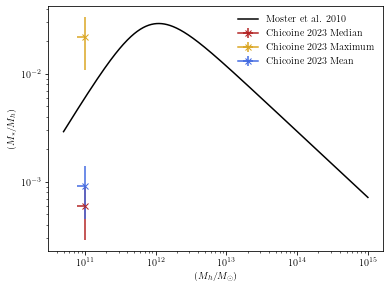

In [344]:
#Plot comparing the parameterized SHMR to the SHMR for this work with errorbars derived from propagation
fig = plt.figure(figsize=(6,4.5))
plt.plot((m_halo_ex_red), (m_stellar_ex_red/m_halo_ex_red), color='black', label='Moster et al. 2010')
plt.errorbar(M_halo_red, np.median(m_stellar_red)/M_halo_red, xerr = asymmetric_error, yerr = np.median(shmr_error_red), marker='x', color='firebrick', label='Chicoine 2023 Median')
plt.errorbar(M_halo_red, np.max(m_stellar_red)/M_halo_red, xerr = asymmetric_error, yerr = np.max(shmr_error_red), marker='x', color='goldenrod', label='Chicoine 2023 Maximum')
plt.errorbar(M_halo_red, np.mean(m_stellar_red)/M_halo_red, xerr = asymmetric_error, yerr = np.mean(shmr_error_red), marker='x', color='royalblue', label='Chicoine 2023 Mean')
plt.xlabel('$(M_h/M_{\odot})$')
plt.ylabel('$(M_*/M_h)$')
plt.xscale('log')
plt.yscale('log')
plt.legend(frameon=False)
plt.savefig('shmr.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [345]:
#Obtaining the errorbars of the parameterized SHMR
#Calculation of parameterized SHMR at various masses
m_stellar_ex_red_1 = 5e10 * 2 * A * (((5e10/M_char)**(-1*beta)) + ((5e10/M_char)**gamma))**(-1)
m_stellar_ex_red_1_5 = 7e10 * 2 * A * (((7e10/M_char)**(-1*beta)) + ((7e10/M_char)**gamma))**(-1)
m_stellar_ex_red_2 = 1e11 * 2 * A * (((1e11/M_char)**(-1*beta)) + ((1e11/M_char)**gamma))**(-1)
m_stellar_ex_red_2_5 = 3e11 * 2 * A * (((3e11/M_char)**(-1*beta)) + ((3e11/M_char)**gamma))**(-1)
m_stellar_ex_red_3 = 5e11 * 2 * A * (((5e11/M_char)**(-1*beta)) + ((5e11/M_char)**gamma))**(-1)
m_stellar_ex_red_3_5 = 7e11 * 2 * A * (((7e11/M_char)**(-1*beta)) + ((7e11/M_char)**gamma))**(-1)
m_stellar_ex_red_4 = 1e12 * 2 * A * (((1e12/M_char)**(-1*beta)) + ((1e12/M_char)**gamma))**(-1)
m_stellar_ex_red_4_5 = 3e12 * 2 * A * (((3e12/M_char)**(-1*beta)) + ((3e12/M_char)**gamma))**(-1)
m_stellar_ex_red_5 = 5e12 * 2 * A * (((5e12/M_char)**(-1*beta)) + ((5e12/M_char)**gamma))**(-1)
m_stellar_ex_red_5_5 = 7e12 * 2 * A * (((7e12/M_char)**(-1*beta)) + ((7e12/M_char)**gamma))**(-1)
m_stellar_ex_red_6 = 1e13 * 2 * A * (((1e13/M_char)**(-1*beta)) + ((1e13/M_char)**gamma))**(-1)
m_stellar_ex_red_6_5 = 3e13 * 2 * A * (((3e13/M_char)**(-1*beta)) + ((3e13/M_char)**gamma))**(-1)
m_stellar_ex_red_7 = 5e13 * 2 * A * (((5e13/M_char)**(-1*beta)) + ((5e13/M_char)**gamma))**(-1)
m_stellar_ex_red_7_5 = 7e13 * 2 * A * (((7e13/M_char)**(-1*beta)) + ((7e13/M_char)**gamma))**(-1)
m_stellar_ex_red_8 = 1e14 * 2 * A * (((1e14/M_char)**(-1*beta)) + ((1e14/M_char)**gamma))**(-1)
m_stellar_ex_red_8_5 = 3e14 * 2 * A * (((3e14/M_char)**(-1*beta)) + ((3e14/M_char)**gamma))**(-1)
m_stellar_ex_red_9 = 5e14 * 2 * A * (((5e14/M_char)**(-1*beta)) + ((5e14/M_char)**gamma))**(-1)
m_stellar_ex_red_9_5 = 7e14 * 2 * A * (((7e14/M_char)**(-1*beta)) + ((7e14/M_char)**gamma))**(-1)
m_stellar_ex_red_10 = 1e15 * 2 * A * (((1e15/M_char)**(-1*beta)) + ((1e15/M_char)**gamma))**(-1)

#Creating a list of the stellar masses calculated with the parameterized SHMR
m_stellar_ex_red_points = [m_stellar_ex_red_1, m_stellar_ex_red_2, m_stellar_ex_red_3, m_stellar_ex_red_4, m_stellar_ex_red_5, m_stellar_ex_red_6, m_stellar_ex_red_7, m_stellar_ex_red_8, m_stellar_ex_red_9, m_stellar_ex_red_10]

#We define the error on the parameters for the parameterized SHMR as 2x error to get the broader errorbands
A_err = 2*0.00063
M_char_err = 2*10**0.026
beta_err = 2*0.051
gamma_err = 2*0.012

#We resample the SHMR and stellar mass over the uncertainties of the parameters for various masses

sampled_stellar_mass_1 = []
for i in range(10000):
    A_samp = np.random.normal(loc=A, scale=A_err)
    beta_samp = np.random.normal(loc=beta, scale=beta_err)
    gamma_samp = np.random.normal(loc=gamma, scale=gamma_err)
    M_char_samp = np.random.normal(loc=M_char, scale=M_char_err)
    sampled_stellar_mass_obj_1 = 5e10 * 2 * A_samp * (((5e10/M_char_samp)**(-1*beta_samp)) + ((5e10/M_char_samp)**gamma_samp))**(-1)
    sampled_stellar_mass_1.append(sampled_stellar_mass_obj_1)

sampled_stellar_mass_1_5 = []
for i in range(10000):
    A_samp_1_5 = np.random.normal(loc=A, scale=A_err)
    beta_samp_1_5 = np.random.normal(loc=beta, scale=beta_err)
    gamma_samp_1_5 = np.random.normal(loc=gamma, scale=gamma_err)
    M_char_samp_1_5 = np.random.normal(loc=M_char, scale=M_char_err)
    sampled_stellar_mass_obj_1_5 = 7e10 * 2 * A_samp_1_5 * (((7e10/M_char_samp_1_5)**(-1*beta_samp_1_5)) + ((7e10/M_char_samp_1_5)**gamma_samp_1_5))**(-1)
    sampled_stellar_mass_1_5.append(sampled_stellar_mass_obj_1_5)

sampled_stellar_mass_2 = []
for i in range(10000):
    A_samp_2 = np.random.normal(loc=A, scale=A_err)
    beta_samp_2 = np.random.normal(loc=beta, scale=beta_err)
    gamma_samp_2 = np.random.normal(loc=gamma, scale=gamma_err)
    M_char_samp_2 = np.random.normal(loc=M_char, scale=M_char_err)
    sampled_stellar_mass_obj_2 = 1e11 * 2 * A_samp_2 * (((1e11/M_char_samp_2)**(-1*beta_samp_2)) + ((1e11/M_char_samp_2)**gamma_samp_2))**(-1)
    sampled_stellar_mass_2.append(sampled_stellar_mass_obj_2)
    
sampled_stellar_mass_2_5 = []
for i in range(10000):
    A_samp_2_5 = np.random.normal(loc=A, scale=A_err)
    beta_samp_2_5 = np.random.normal(loc=beta, scale=beta_err)
    gamma_samp_2_5 = np.random.normal(loc=gamma, scale=gamma_err)
    M_char_samp_2_5 = np.random.normal(loc=M_char, scale=M_char_err)
    sampled_stellar_mass_obj_2_5 = 3e11 * 2 * A_samp_2_5 * (((3e11/M_char_samp_2_5)**(-1*beta_samp_2_5)) + ((3e11/M_char_samp_2_5)**gamma_samp_2_5))**(-1)
    sampled_stellar_mass_2_5.append(sampled_stellar_mass_obj_2_5)

sampled_stellar_mass_3 = []
for i in range(10000):
    A_samp_3 = np.random.normal(loc=A, scale=A_err)
    beta_samp_3 = np.random.normal(loc=beta, scale=beta_err)
    gamma_samp_3 = np.random.normal(loc=gamma, scale=gamma_err)
    M_char_samp_3 = np.random.normal(loc=M_char, scale=M_char_err)
    sampled_stellar_mass_obj_3 = 5e11 * 2 * A_samp_3 * (((5e11/M_char_samp_3)**(-1*beta_samp_3)) + ((5e11/M_char_samp_3)**gamma_samp_3))**(-1)
    sampled_stellar_mass_3.append(sampled_stellar_mass_obj_3)
    
sampled_stellar_mass_3_5 = []
for i in range(10000):
    A_samp_3_5 = np.random.normal(loc=A, scale=A_err)
    beta_samp_3_5 = np.random.normal(loc=beta, scale=beta_err)
    gamma_samp_3_5 = np.random.normal(loc=gamma, scale=gamma_err)
    M_char_samp_3_5 = np.random.normal(loc=M_char, scale=M_char_err)
    sampled_stellar_mass_obj_3_5 = 7e11 * 2 * A_samp_3_5 * (((7e11/M_char_samp_3_5)**(-1*beta_samp_3_5)) + ((7e11/M_char_samp_3_5)**gamma_samp_3_5))**(-1)
    sampled_stellar_mass_3_5.append(sampled_stellar_mass_obj_3_5)

sampled_stellar_mass_4 = []
for i in range(10000):
    A_samp_4 = np.random.normal(loc=A, scale=A_err)
    beta_samp_4 = np.random.normal(loc=beta, scale=beta_err)
    gamma_samp_4 = np.random.normal(loc=gamma, scale=gamma_err)
    M_char_samp_4 = np.random.normal(loc=M_char, scale=M_char_err)
    sampled_stellar_mass_obj_4 = 1e12 * 2 * A_samp_4 * (((1e12/M_char_samp_4)**(-1*beta_samp_4)) + ((1e12/M_char_samp_4)**gamma_samp_4))**(-1)
    sampled_stellar_mass_4.append(sampled_stellar_mass_obj_4)

sampled_stellar_mass_4_5 = []
for i in range(10000):
    A_samp_4_5 = np.random.normal(loc=A, scale=A_err)
    beta_samp_4_5 = np.random.normal(loc=beta, scale=beta_err)
    gamma_samp_4_5 = np.random.normal(loc=gamma, scale=gamma_err)
    M_char_samp_4_5 = np.random.normal(loc=M_char, scale=M_char_err)
    sampled_stellar_mass_obj_4_5 = 3e12 * 2 * A_samp_4_5 * (((3e12/M_char_samp_4_5)**(-1*beta_samp_4_5)) + ((3e12/M_char_samp_4_5)**gamma_samp_4_5))**(-1)
    sampled_stellar_mass_4_5.append(sampled_stellar_mass_obj_4_5)


sampled_stellar_mass_5 = []
for i in range(10000):
    A_samp_5 = np.random.normal(loc=A, scale=A_err)
    beta_samp_5 = np.random.normal(loc=beta, scale=beta_err)
    gamma_samp_5 = np.random.normal(loc=gamma, scale=gamma_err)
    M_char_samp_5 = np.random.normal(loc=M_char, scale=M_char_err)
    sampled_stellar_mass_obj_5 = 5e12 * 2 * A_samp_5 * (((5e12/M_char_samp_5)**(-1*beta_samp_5)) + ((5e12/M_char_samp_5)**gamma_samp_5))**(-1)
    sampled_stellar_mass_5.append(sampled_stellar_mass_obj_5)

sampled_stellar_mass_5_5 = []
for i in range(10000):
    A_samp_5_5 = np.random.normal(loc=A, scale=A_err)
    beta_samp_5_5 = np.random.normal(loc=beta, scale=beta_err)
    gamma_samp_5_5 = np.random.normal(loc=gamma, scale=gamma_err)
    M_char_samp_5_5 = np.random.normal(loc=M_char, scale=M_char_err)
    sampled_stellar_mass_obj_5_5 = 7e12 * 2 * A_samp_5_5 * (((7e12/M_char_samp_5_5)**(-1*beta_samp_5_5)) + ((7e12/M_char_samp_5_5)**gamma_samp_5_5))**(-1)
    sampled_stellar_mass_5_5.append(sampled_stellar_mass_obj_5_5)

sampled_stellar_mass_6 = []
for i in range(10000):
    A_samp_6 = np.random.normal(loc=A, scale=A_err)
    beta_samp_6 = np.random.normal(loc=beta, scale=beta_err)
    gamma_samp_6 = np.random.normal(loc=gamma, scale=gamma_err)
    M_char_samp_6 = np.random.normal(loc=M_char, scale=M_char_err)
    sampled_stellar_mass_obj_6 = 1e13 * 2 * A_samp_6 * (((1e13/M_char_samp_6)**(-1*beta_samp_6)) + ((1e13/M_char_samp_6)**gamma_samp_6))**(-1)
    sampled_stellar_mass_6.append(sampled_stellar_mass_obj_6)
    
sampled_stellar_mass_6_5 = []
for i in range(10000):
    A_samp_6_5 = np.random.normal(loc=A, scale=A_err)
    beta_samp_6_5 = np.random.normal(loc=beta, scale=beta_err)
    gamma_samp_6_5 = np.random.normal(loc=gamma, scale=gamma_err)
    M_char_samp_6_5 = np.random.normal(loc=M_char, scale=M_char_err)
    sampled_stellar_mass_obj_6_5 = 3e13 * 2 * A_samp_6_5 * (((3e13/M_char_samp_6_5)**(-1*beta_samp_6_5)) + ((3e13/M_char_samp_6_5)**gamma_samp_6_5))**(-1)
    sampled_stellar_mass_6_5.append(sampled_stellar_mass_obj_6_5)

sampled_stellar_mass_7 = []
for i in range(10000):
    A_samp_7 = np.random.normal(loc=A, scale=A_err)
    beta_samp_7 = np.random.normal(loc=beta, scale=beta_err)
    gamma_samp_7 = np.random.normal(loc=gamma, scale=gamma_err)
    M_char_samp_7 = np.random.normal(loc=M_char, scale=M_char_err)
    sampled_stellar_mass_obj_7 = 5e13 * 2 * A_samp_7 * (((5e13/M_char_samp_7)**(-1*beta_samp_7)) + ((5e13/M_char_samp_7)**gamma_samp_7))**(-1)
    sampled_stellar_mass_7.append(sampled_stellar_mass_obj_7)

sampled_stellar_mass_7_5 = []
for i in range(10000):
    A_samp_7_5 = np.random.normal(loc=A, scale=A_err)
    beta_samp_7_5 = np.random.normal(loc=beta, scale=beta_err)
    gamma_samp_7_5 = np.random.normal(loc=gamma, scale=gamma_err)
    M_char_samp_7_5 = np.random.normal(loc=M_char, scale=M_char_err)
    sampled_stellar_mass_obj_7_5 = 7e13 * 2 * A_samp_7_5 * (((7e13/M_char_samp_7_5)**(-1*beta_samp_7_5)) + ((7e13/M_char_samp_7_5)**gamma_samp_7_5))**(-1)
    sampled_stellar_mass_7_5.append(sampled_stellar_mass_obj_7_5)

sampled_stellar_mass_8 = []
for i in range(10000):
    A_samp_8 = np.random.normal(loc=A, scale=A_err)
    beta_samp_8 = np.random.normal(loc=beta, scale=beta_err)
    gamma_samp_8 = np.random.normal(loc=gamma, scale=gamma_err)
    M_char_samp_8 = np.random.normal(loc=M_char, scale=M_char_err)
    sampled_stellar_mass_obj_8 = 1e14 * 2 * A_samp_8 * (((1e14/M_char_samp_8)**(-1*beta_samp_8)) + ((1e14/M_char_samp_8)**gamma_samp_8))**(-1)
    sampled_stellar_mass_8.append(sampled_stellar_mass_obj_8)

sampled_stellar_mass_8_5 = []
for i in range(10000):
    A_samp_8_5 = np.random.normal(loc=A, scale=A_err)
    beta_samp_8_5 = np.random.normal(loc=beta, scale=beta_err)
    gamma_samp_8_5 = np.random.normal(loc=gamma, scale=gamma_err)
    M_char_samp_8_5 = np.random.normal(loc=M_char, scale=M_char_err)
    sampled_stellar_mass_obj_8_5 = 3e14 * 2 * A_samp_8_5 * (((3e14/M_char_samp_8_5)**(-1*beta_samp_8_5)) + ((3e14/M_char_samp_8_5)**gamma_samp_8_5))**(-1)
    sampled_stellar_mass_8_5.append(sampled_stellar_mass_obj_8_5)


sampled_stellar_mass_9 = []
for i in range(10000):
    A_samp_9 = np.random.normal(loc=A, scale=A_err)
    beta_samp_9 = np.random.normal(loc=beta, scale=beta_err)
    gamma_samp_9 = np.random.normal(loc=gamma, scale=gamma_err)
    M_char_samp_9 = np.random.normal(loc=M_char, scale=M_char_err)
    sampled_stellar_mass_obj_9 = 5e14 * 2 * A_samp_9 * (((5e14/M_char_samp_9)**(-1*beta_samp_9)) + ((5e14/M_char_samp_9)**gamma_samp_9))**(-1)
    sampled_stellar_mass_9.append(sampled_stellar_mass_obj_9)

sampled_stellar_mass_9_5 = []
for i in range(10000):
    A_samp_9_5 = np.random.normal(loc=A, scale=A_err)
    beta_samp_9_5 = np.random.normal(loc=beta, scale=beta_err)
    gamma_samp_9_5 = np.random.normal(loc=gamma, scale=gamma_err)
    M_char_samp_9_5 = np.random.normal(loc=M_char, scale=M_char_err)
    sampled_stellar_mass_obj_9_5 = 7e14 * 2 * A_samp_9_5 * (((7e14/M_char_samp_9_5)**(-1*beta_samp_9_5)) + ((7e14/M_char_samp_9_5)**gamma_samp_9_5))**(-1)
    sampled_stellar_mass_9_5.append(sampled_stellar_mass_obj_9_5)
    
sampled_stellar_mass_10 = []
for i in range(10000):
    A_samp_10 = np.random.normal(loc=A, scale=A_err)
    beta_samp_10 = np.random.normal(loc=beta, scale=beta_err)
    gamma_samp_10 = np.random.normal(loc=gamma, scale=gamma_err)
    M_char_samp_10 = np.random.normal(loc=M_char, scale=M_char_err)
    sampled_stellar_mass_obj_10 = 1e15 * 2 * A_samp_10 * (((1e15/M_char_samp_10)**(-1*beta_samp_10)) + ((1e15/M_char_samp_10)**gamma_samp_10))**(-1)
    sampled_stellar_mass_10.append(sampled_stellar_mass_obj_10)


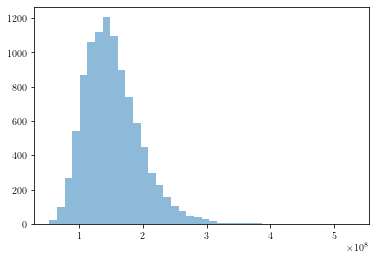

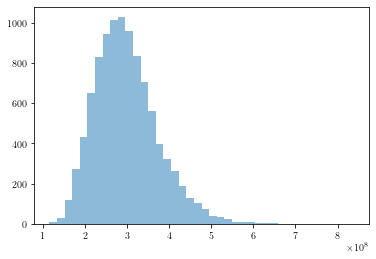

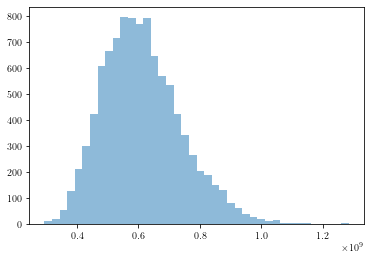

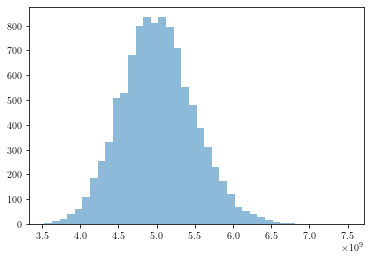

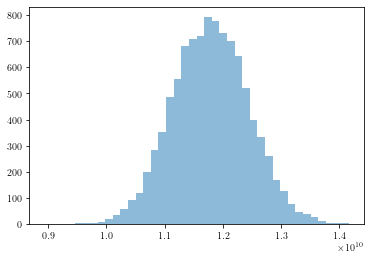

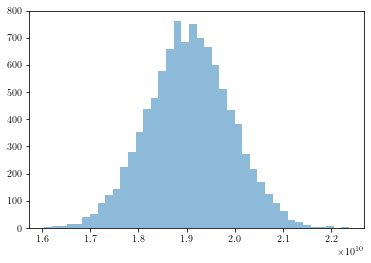

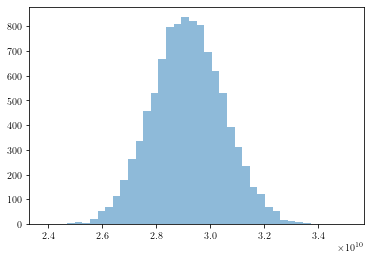

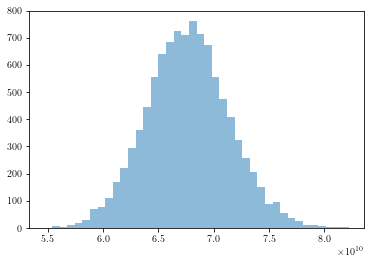

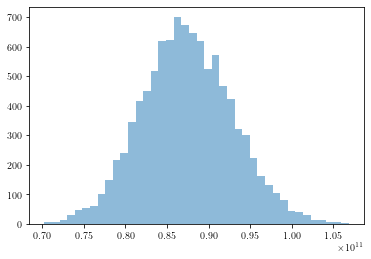

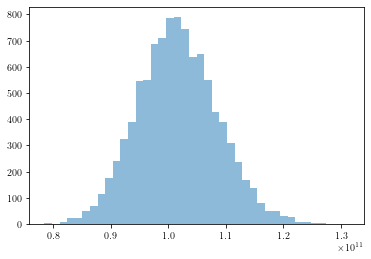

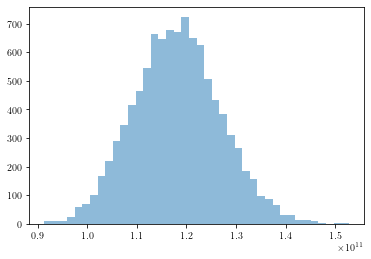

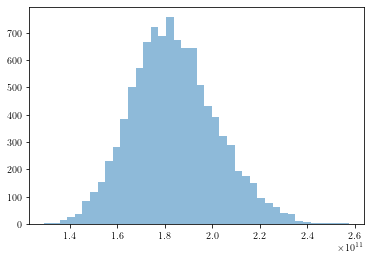

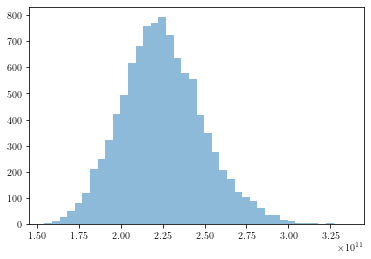

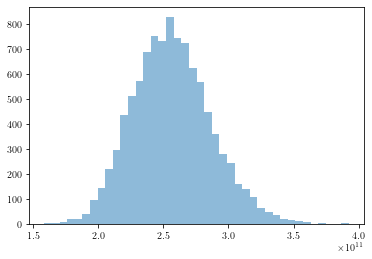

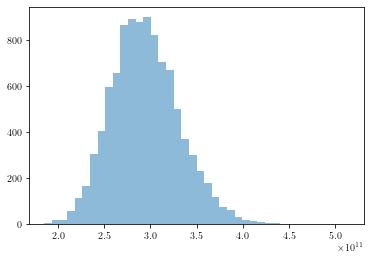

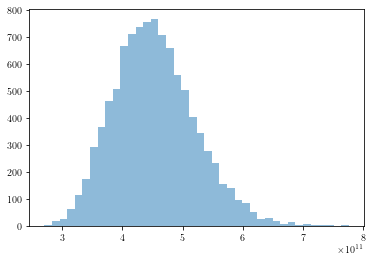

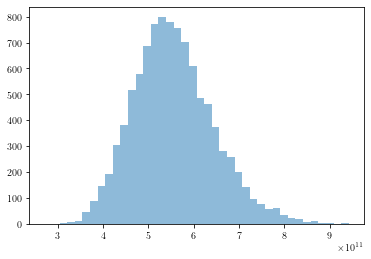

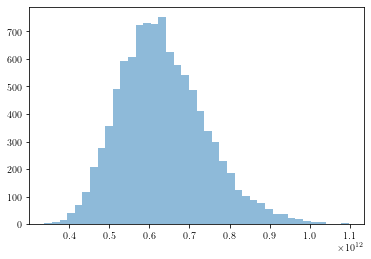

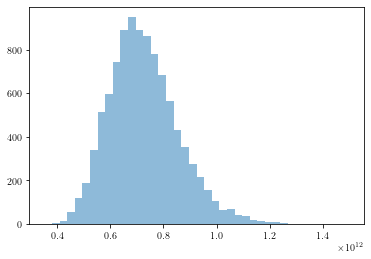

In [346]:
#We show the histograms of the resampled stellar masses derived from the parameterized SHMR
plt.hist(sampled_stellar_mass_1, bins=40, alpha=0.5, label="SHMR Stellar Mass Sample 1")
plt.show()

plt.hist(sampled_stellar_mass_1_5, bins=40, alpha=0.5, label="SHMR Stellar Mass Sample 1.5")
plt.show()


plt.hist(sampled_stellar_mass_2, bins=40, alpha=0.5, label="SHMR Stellar Mass Sample 2")
plt.show()

plt.hist(sampled_stellar_mass_2_5, bins=40, alpha=0.5, label="SHMR Stellar Mass Sample 2.5")
plt.show()


plt.hist(sampled_stellar_mass_3, bins=40, alpha=0.5, label="SHMR Stellar Mass Sample 3")
plt.show()

plt.hist(sampled_stellar_mass_3_5, bins=40, alpha=0.5, label="SHMR Stellar Mass Sample 3.5")
plt.show()

plt.hist(sampled_stellar_mass_4, bins=40, alpha=0.5, label="SHMR Stellar Mass Sample 4")
plt.show()

plt.hist(sampled_stellar_mass_4_5, bins=40, alpha=0.5, label="SHMR Stellar Mass Sample 4.5")
plt.show()

plt.hist(sampled_stellar_mass_5, bins=40, alpha=0.5, label="SHMR Stellar Mass Sample 5")
plt.show()

plt.hist(sampled_stellar_mass_5_5, bins=40, alpha=0.5, label="SHMR Stellar Mass Sample 5.5")
plt.show()

plt.hist(sampled_stellar_mass_6, bins=40, alpha=0.5, label="SHMR Stellar Mass Sample 6")
plt.show()

plt.hist(sampled_stellar_mass_6_5, bins=40, alpha=0.5, label="SHMR Stellar Mass Sample 6.5")
plt.show()

plt.hist(sampled_stellar_mass_7, bins=40, alpha=0.5, label="SHMR Stellar Mass Sample 7")
plt.show()

plt.hist(sampled_stellar_mass_7_5, bins=40, alpha=0.5, label="SHMR Stellar Mass Sample 7.5")
plt.show()

plt.hist(sampled_stellar_mass_8, bins=40, alpha=0.5, label="SHMR Stellar Mass Sample 8")
plt.show()

plt.hist(sampled_stellar_mass_8_5, bins=40, alpha=0.5, label="SHMR Stellar Mass Sample 8.5")
plt.show()

plt.hist(sampled_stellar_mass_9, bins=40, alpha=0.5, label="SHMR Stellar Mass Sample 9")
plt.show()

plt.hist(sampled_stellar_mass_9_5, bins=40, alpha=0.5, label="SHMR Stellar Mass Sample 9.5")
plt.show()

plt.hist(sampled_stellar_mass_10, bins=40, alpha=0.5, label="SHMR Stellar Mass Sample 10")
plt.show()

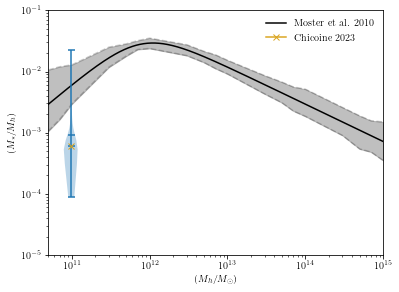

In [347]:
#We define the spread of the stellar mass values derived from the resampled parameterized SHMR
sampled_stellar_mass_1_spread = [np.min(sampled_stellar_mass_1)*y/5e10, np.max(sampled_stellar_mass_1)*y/5e10]
sampled_stellar_mass_1_5_spread = [np.min(sampled_stellar_mass_1_5)*y/7e10, np.max(sampled_stellar_mass_1_5)*y/7e10]
sampled_stellar_mass_2_spread = [np.min(sampled_stellar_mass_2)*y/1e11, np.max(sampled_stellar_mass_2)*y/1e11]
sampled_stellar_mass_2_5_spread = [np.min(sampled_stellar_mass_2_5)*y/3e11, np.max(sampled_stellar_mass_2_5)*y/3e11]
sampled_stellar_mass_3_spread = [np.min(sampled_stellar_mass_3)*y/5e11, np.max(sampled_stellar_mass_3)*y/5e11]
sampled_stellar_mass_3_5_spread = [np.min(sampled_stellar_mass_3_5)*y/7e11, np.max(sampled_stellar_mass_3_5)*y/7e11]
sampled_stellar_mass_4_spread = [np.min(sampled_stellar_mass_4)*y/1e12, np.max(sampled_stellar_mass_4)*y/1e12]
sampled_stellar_mass_4_5_spread = [np.min(sampled_stellar_mass_4_5)*y/3e12, np.max(sampled_stellar_mass_4_5)*y/3e12]
sampled_stellar_mass_5_spread = [np.min(sampled_stellar_mass_5)*y/5e12, np.max(sampled_stellar_mass_5)*y/5e12]
sampled_stellar_mass_5_5_spread = [np.min(sampled_stellar_mass_5_5)*y/7e12, np.max(sampled_stellar_mass_5_5)*y/7e12]
sampled_stellar_mass_6_spread = [np.min(sampled_stellar_mass_6)*y/1e13, np.max(sampled_stellar_mass_6)*y/1e13]
sampled_stellar_mass_6_5_spread = [np.min(sampled_stellar_mass_6_5)*y/3e13, np.max(sampled_stellar_mass_6_5)*y/3e13]
sampled_stellar_mass_7_spread = [np.min(sampled_stellar_mass_7)*y/5e13, np.max(sampled_stellar_mass_7)*y/5e13]
sampled_stellar_mass_7_5_spread = [np.min(sampled_stellar_mass_7_5)*y/7e13, np.max(sampled_stellar_mass_7_5)*y/7e13]
sampled_stellar_mass_8_spread = [np.min(sampled_stellar_mass_8)*y/1e14, np.max(sampled_stellar_mass_8)*y/1e14]
sampled_stellar_mass_8_5_spread = [np.min(sampled_stellar_mass_8_5)*y/3e14, np.max(sampled_stellar_mass_8_5)*y/3e14]
sampled_stellar_mass_9_spread = [np.min(sampled_stellar_mass_9)*y/5e14, np.max(sampled_stellar_mass_9)*y/5e14]
sampled_stellar_mass_9_5_spread = [np.min(sampled_stellar_mass_9_5)*y/7e14, np.max(sampled_stellar_mass_9_5)*y/7e14]
sampled_stellar_mass_10_spread = [np.min(sampled_stellar_mass_10)*y/1e15, np.max(sampled_stellar_mass_10)*y/1e15]

#We define points on the x-axis for the halo masses 
x_spread = np.array([5e10, 7e10, 1e11, 3e11, 5e11, 7e11, 1e12, 3e12, 5e12, 7e12, 1e13, 3e13, 5e13, 7e13, 1e14, 3e14, 5e14, 7e14, 1e15])
#This curve represents the upper boundary
y_max_spread = np.array([np.max(sampled_stellar_mass_1)/5e10, np.max(sampled_stellar_mass_1_5)/7e10, np.max(sampled_stellar_mass_2)/1e11, np.max(sampled_stellar_mass_2_5)/3e11, np.max(sampled_stellar_mass_3)/5e11, np.max(sampled_stellar_mass_3_5)/7e11, np.max(sampled_stellar_mass_4)/1e12, np.max(sampled_stellar_mass_4_5)/3e12, np.max(sampled_stellar_mass_5)/5e12, np.max(sampled_stellar_mass_5_5)/7e12, np.max(sampled_stellar_mass_6)/1e13, np.max(sampled_stellar_mass_6_5)/3e13, np.max(sampled_stellar_mass_7)/5e13, np.max(sampled_stellar_mass_7_5)/7e13, np.max(sampled_stellar_mass_8)/1e14, np.max(sampled_stellar_mass_8_5)/3e14, np.max(sampled_stellar_mass_9)/5e14,  np.max(sampled_stellar_mass_9_5)/7e14, np.max(sampled_stellar_mass_10)/1e15])
#This curve represents the lower boundary
y_min_spread = np.array([np.min(sampled_stellar_mass_1)/5e10, np.min(sampled_stellar_mass_1_5)/7e10, np.min(sampled_stellar_mass_2)/1e11, np.min(sampled_stellar_mass_2_5)/3e11, np.min(sampled_stellar_mass_3)/5e11, np.min(sampled_stellar_mass_3_5)/7e11, np.min(sampled_stellar_mass_4)/1e12, np.min(sampled_stellar_mass_4_5)/3e12, np.min(sampled_stellar_mass_5)/5e12, np.min(sampled_stellar_mass_5_5)/7e12, np.min(sampled_stellar_mass_6)/1e13, np.min(sampled_stellar_mass_6_5)/3e13, np.min(sampled_stellar_mass_7)/5e13, np.min(sampled_stellar_mass_7_5)/7e13, np.min(sampled_stellar_mass_8)/1e14, np.min(sampled_stellar_mass_8_5)/3e14, np.min(sampled_stellar_mass_9)/5e14,  np.min(sampled_stellar_mass_9_5)/7e14, np.min(sampled_stellar_mass_10)/1e15])

fig = plt.figure(figsize=(6,4.5))
plt.fill_between(x_spread, y_min_spread, y_max_spread, color='grey', alpha=0.5) #Filling between the upper and lower boundaries of the parameterized SHMR
plt.plot(x_spread, y_min_spread, color='black', linestyle='--', alpha=0.2)
plt.plot(x_spread, y_max_spread, color='black', linestyle='--', alpha=0.2)
pos = [9.9e10] #Subhalo mass- position for the SHMR calculation for this dataset
plt.plot((m_halo_ex_red), (m_stellar_ex_red/m_halo_ex_red), color='black', label='Moster et al. 2010') #Parameterized SHMR
plt.violinplot((m_stellar_red)/M_halo_red, pos, widths=4e10, showmeans=True, showmedians=True, vert=True) #Violin plot illustrating the spread of our calculation of the SHMR
plt.plot(M_halo_red, np.median(m_stellar_red)/M_halo_red, color='goldenrod', marker='x', label='Chicoine 2023') #Marker for the median of our calculation of the SHMR distribution

plt.legend(frameon=False)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$(M_h/M_{\odot})$')
plt.ylabel('$(M_*/M_h)$')
plt.ylim(1e-5, 1e-1)
plt.xlim(5e10, 1e15)
plt.savefig('shmr.pdf', dpi=300, bbox_inches='tight')
plt.show()


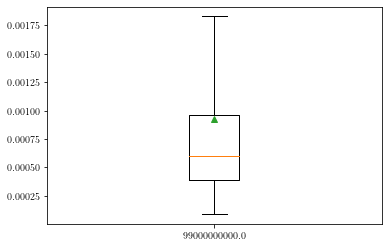

In [349]:
#Zoomed in boxplot showing our distribution of stellar masses for the SHMR
plt.boxplot(m_stellar_red/M_halo_red, vert=True, sym='',positions=np.array([M_halo_red]), showmeans=True)
plt.show()

In [350]:
#Printing out information from the stellar mass distribution
print(np.mean(m_stellar_red))
print(np.median(m_stellar_red))
print(np.median(m_stellar_err_red))

91370150.61593145
58989714.99021852
27203148.063063525
